In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Callable
from scipy.spatial.distance import cosine
from sklearn.ensemble import IsolationForest
from xml_parser import get_xml_data, get_reversed_name_dict

In [2]:
warnings.filterwarnings('ignore')

### Let's start with visual analysis of a given data

In [3]:
def draw_channels(xml: str) -> None:
    df = get_xml_data(f'drive/{xml}')
    name_dict = get_reversed_name_dict()
    
    print(f'{xml} length: {len(df)}')
    print(' ')
    
    x = [x for x in df.columns if '_x' in x]
    y = [x for x in df.columns if '_y' in x]
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(xml, fontsize=18, y=0.95)

    for x, y, ax in zip(x, y, axs.ravel()):
        df.plot(x=x, y=y, kind='scatter', ax=ax)
        ax.set_title(f"{name_dict[x.replace('_x', '')]}")
        ax.set_xlabel("Timesteps")
        ax.set_ylabel("Value")

    plt.show()
        
    line = ['-']*110
    print(''.join(line))
    print(' ')

1.xml length: 8192
 


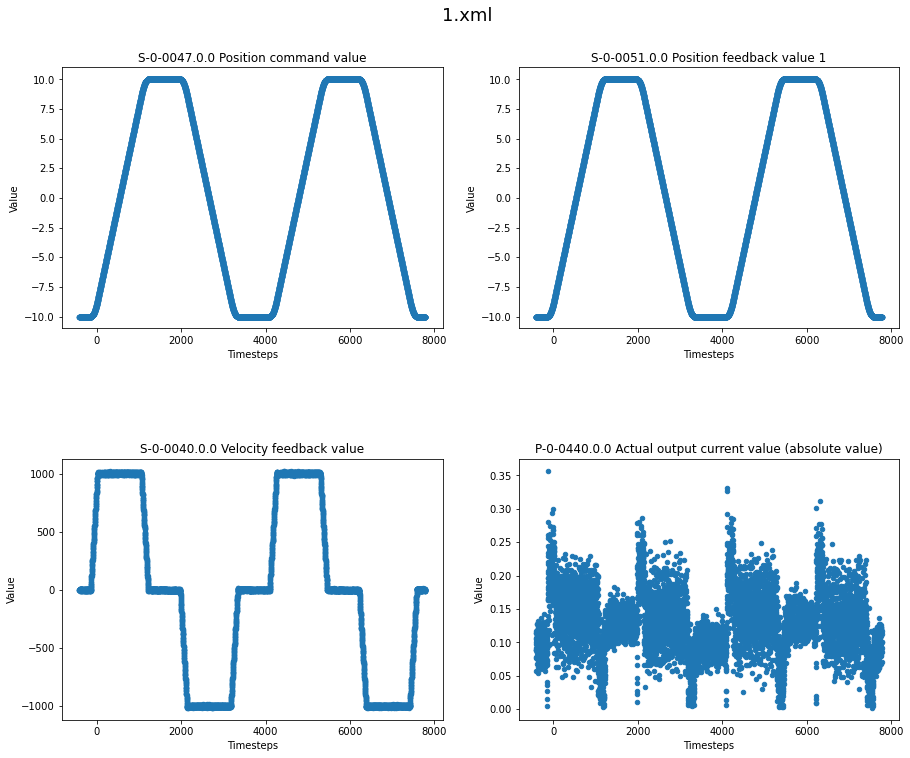

--------------------------------------------------------------------------------------------------------------
 
2.xml length: 8192
 


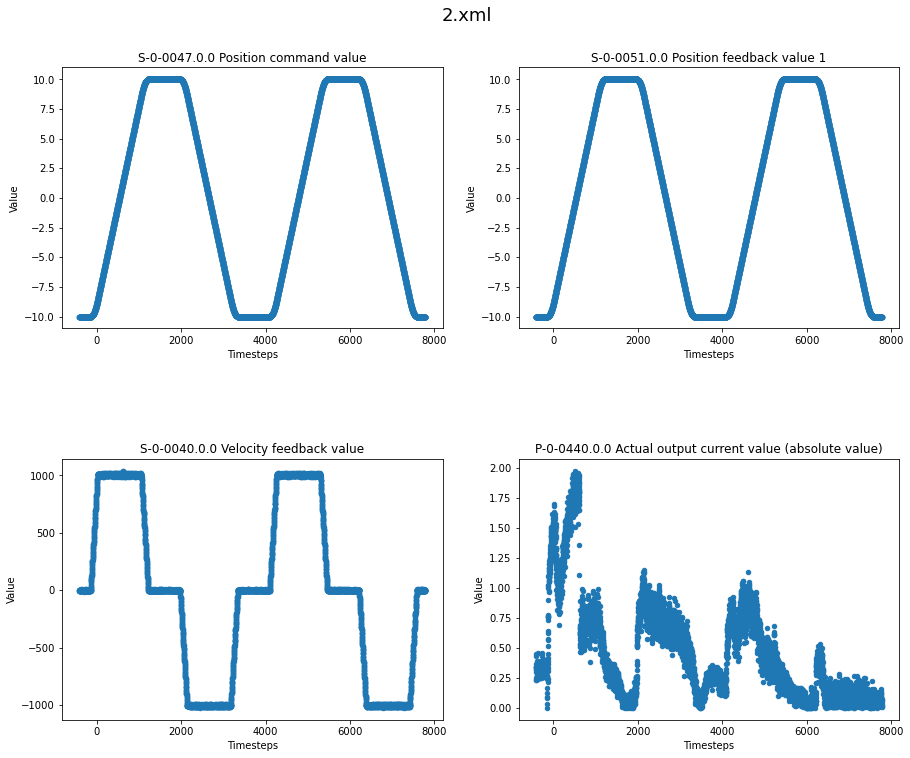

--------------------------------------------------------------------------------------------------------------
 
3.xml length: 8192
 


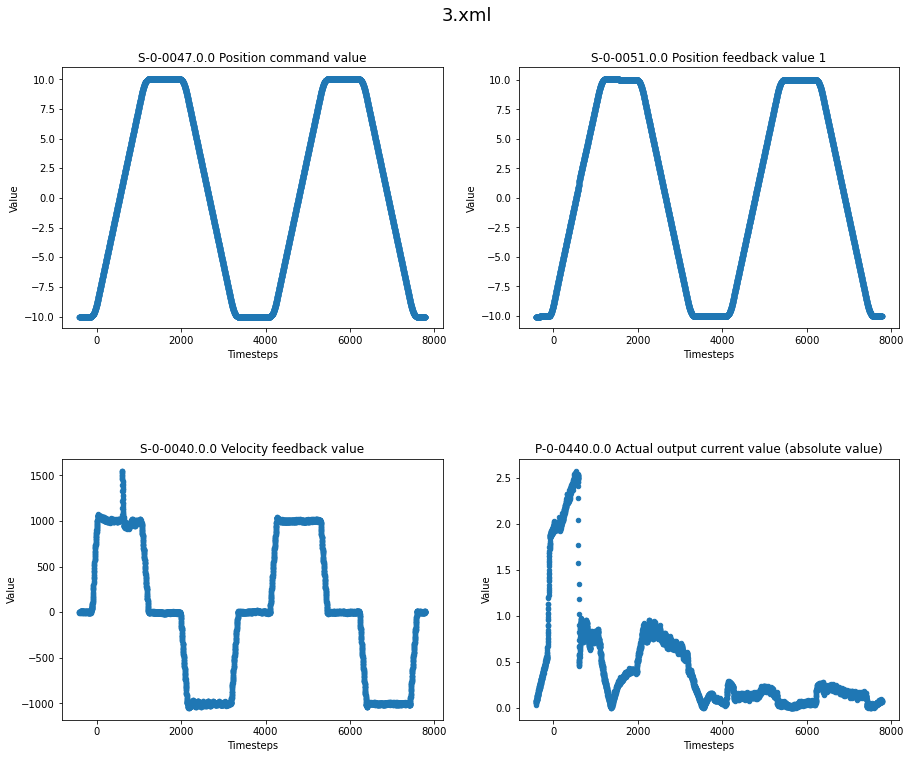

--------------------------------------------------------------------------------------------------------------
 
4.xml length: 8192
 


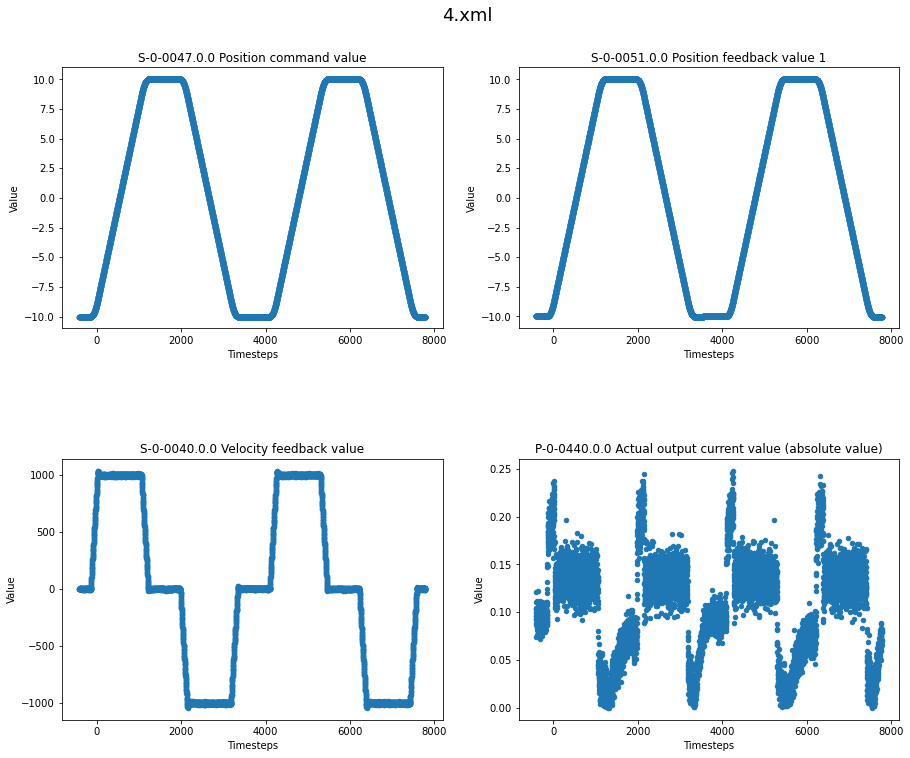

--------------------------------------------------------------------------------------------------------------
 
5.xml length: 8192
 


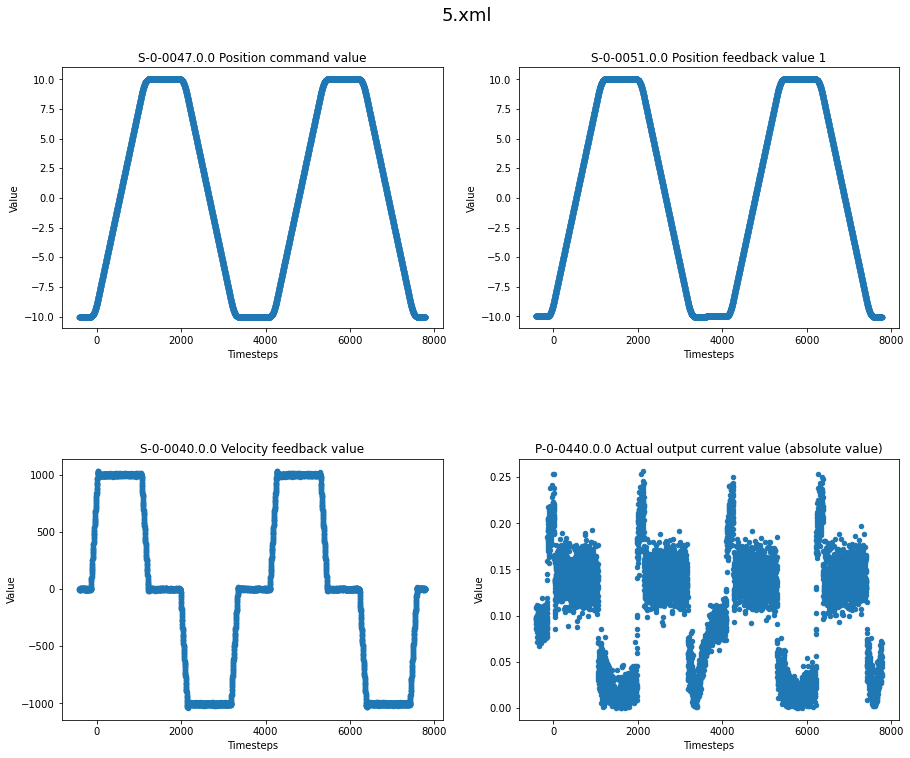

--------------------------------------------------------------------------------------------------------------
 


In [4]:
files = sorted(os.listdir('drive'))

for xml in files:
    draw_channels(xml)

Visual analysis shows that 2.xml and 3.xml definetly have outliers (bad data) on the presented plots in features "Velocity Feedback Value" and especially in "Actual output current value"

Next, we will try to show two methods that can automate the detection of "bad data"

### Hard Code Approcah (Distance-based)

The first approach is based on similarity of features between files, i.e. the files that have the most dissimilar features will be categorised as outliers. For that a simle cosine distance and a predefined threshold will be used, but the current implementation allows user to define own metric if needed.

In [5]:
def extract_as_sequence(data: pd.DataFrame, value: str):
    return data[[f'{value}_x', f'{value}_y']]\
        .rename(columns={f'{value}_x': 'ts', f'{value}_y': 'data'})\
        .set_index('ts')\
        .copy()

In [6]:
xml_data_sequences = {}
name_dict = get_reversed_name_dict()
cols = list(name_dict.keys())

for col in cols:
    df_list = []
    for xml in files:
        df = get_xml_data(f'drive/{xml}')
        df = extract_as_sequence(df, col)
        df = df.rename(columns={'data': f'data_{xml.split(".")[0]}'})
        df_list.append(df)
    sub = pd.concat(df_list, axis=1)
    xml_data_sequences[col] = sub

In [7]:
def cosine_dist(x: np.ndarray, y: np.ndarray) -> float:
    return 1 - cosine(x, y)


def make_dist_matrix(data: dict, col: str, eval_func: Callable, cut_off: float) -> np.ndarray:
    df = data[col].copy()
    cols = list(df.columns)
    matrix = np.zeros((len(cols), len(cols)))
    for i, col_1 in enumerate(cols):
        for j, col_2 in enumerate(cols):
            matrix[i, j] = int(eval_func(df[col_1].values, df[col_2].values) < cut_off)
            
    return matrix


def get_outliers(matrix: np.ndarray) -> list:
    score = []

    for elem in matrix:
        score.append(elem.sum())
        
    return [x > np.mean(np.array(score)) for x in score]


def make_report(data_dict: dict, eval_func: Callable = cosine_dist, cut_off: float = 0.9) -> None:
    name_dict = get_reversed_name_dict()
    cols = list(data_dict.keys())
    
    for col in cols:
        dm = make_dist_matrix(data_dict, col, eval_func, cut_off)
        outliers = get_outliers(dm)
        
        print(name_dict[col], ':')
        for i, res in enumerate(outliers):
            print(f'{i+1}.xml is outlier: {res}')
        
        print(' ')

In [8]:
make_report(xml_data_sequences)

S-0-0047.0.0 Position command value :
1.xml is outlier: False
2.xml is outlier: False
3.xml is outlier: False
4.xml is outlier: False
5.xml is outlier: False
 
S-0-0051.0.0 Position feedback value 1 :
1.xml is outlier: False
2.xml is outlier: False
3.xml is outlier: False
4.xml is outlier: False
5.xml is outlier: False
 
S-0-0040.0.0 Velocity feedback value :
1.xml is outlier: False
2.xml is outlier: False
3.xml is outlier: False
4.xml is outlier: False
5.xml is outlier: False
 
P-0-0440.0.0 Actual output current value (absolute value) :
1.xml is outlier: False
2.xml is outlier: True
3.xml is outlier: True
4.xml is outlier: False
5.xml is outlier: False
 


As we can see this method was able to find "bad data" in feature "Actual output current value" in files 2.xml and 3.xml, but was not sensible enough to detect outliers in feature "Velocity feedback value".

### Machine Learning Approach (Anomaly Detection)

The second approach is based on ML-backed Outlier Detection. It will not compare data from files, but it will try to detect anomalies as all files would be one dataset.

In [9]:
df_list = []
for n in range(1, 6):
    x = ['pcv_x', 'pfv_x', 'vfv_x', 'cv_x']
    y = ['pcv_y', 'pfv_y', 'vfv_y', 'cv_y']
    for x, y in zip(x, y):
        df = get_xml_data(f'drive/{n}.xml')
        df['xml'] = n
        df_list.append(df)
    
data = pd.concat(df_list)
data = data.set_index('pcv_x')
data = data[[x for x in data.columns if 'y' in x] + ['xml']]

In [10]:
matrix = data.drop('xml', axis=1)

model = IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1, max_features=1.0)
preds = model.fit_predict(matrix)

In [11]:
data['anomaly'] = 1 - preds

In [13]:
for c in range(1, 6):
    an_frac = data[data.xml == c].anomaly.sum()/len(data[data.xml == c])
    print(f'{c}.xml fraction of anomalies: {round(an_frac*100, 2)}%')

1.xml fraction of anomalies: 2.98%
2.xml fraction of anomalies: 47.31%
3.xml fraction of anomalies: 43.55%
4.xml fraction of anomalies: 3.2%
5.xml fraction of anomalies: 2.95%


As we can see already files 2.xml and 3.xml have way more outliers as others do.

Let's try to visualize those outliers. But be careful we are not plotting abnormal data, but instead abnormal timesteps, because our model analysed data as whole (all features at once).

In [14]:
data.reset_index(drop=False, inplace=True)

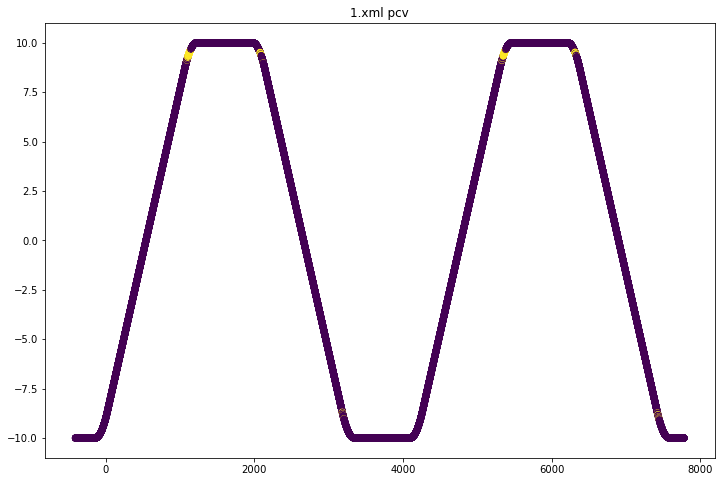

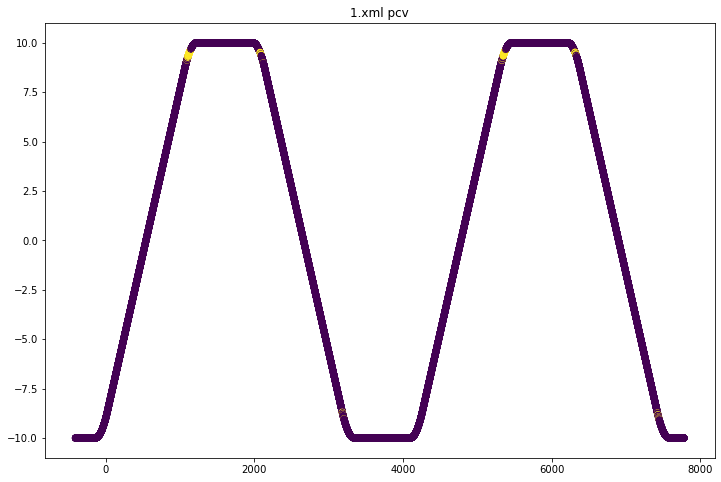

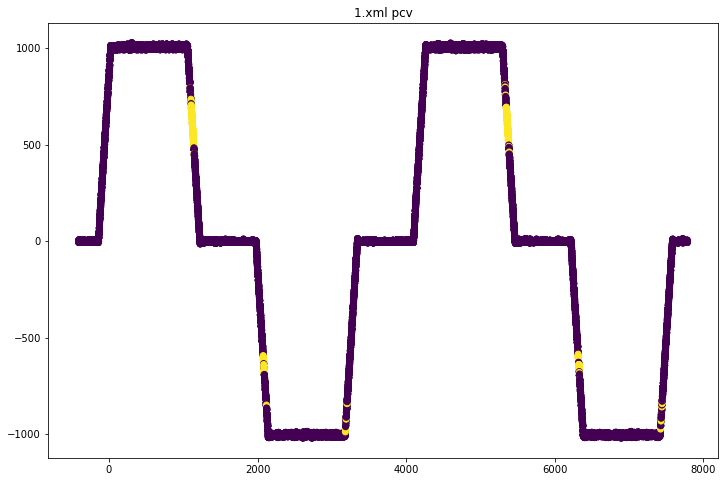

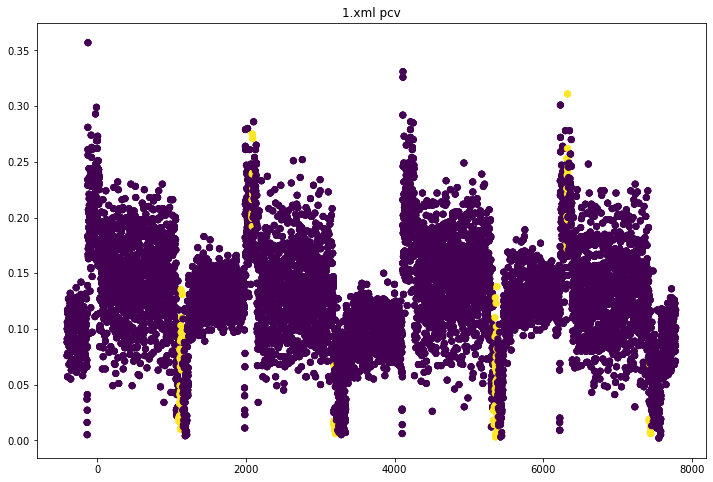

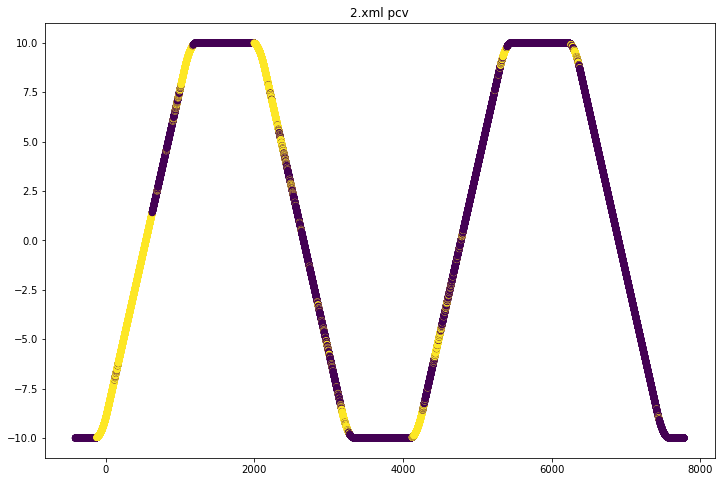

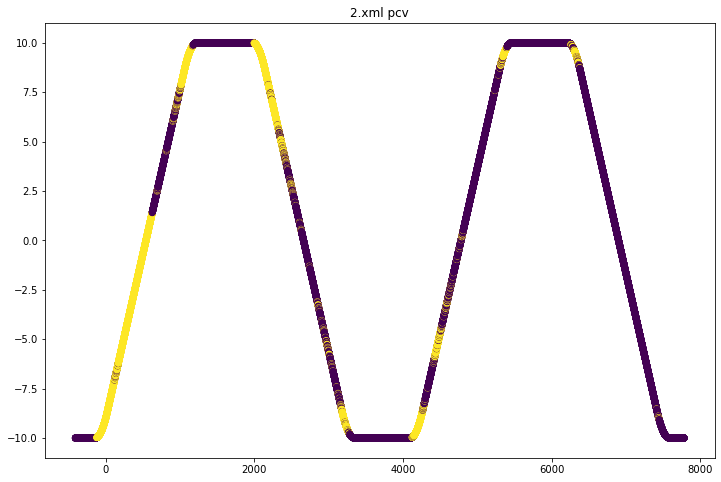

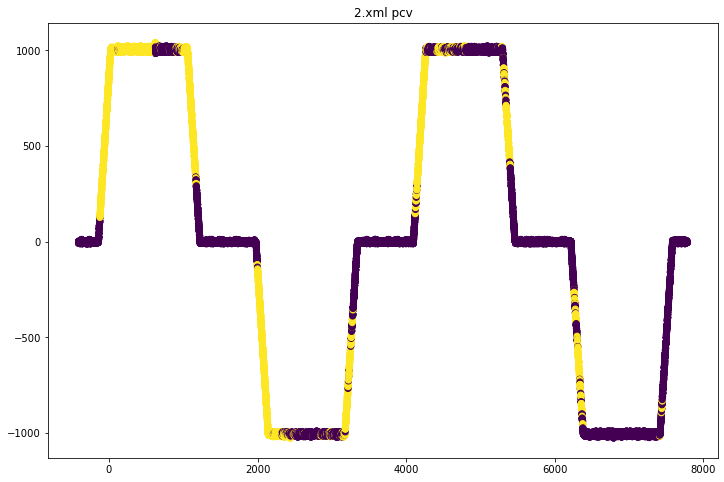

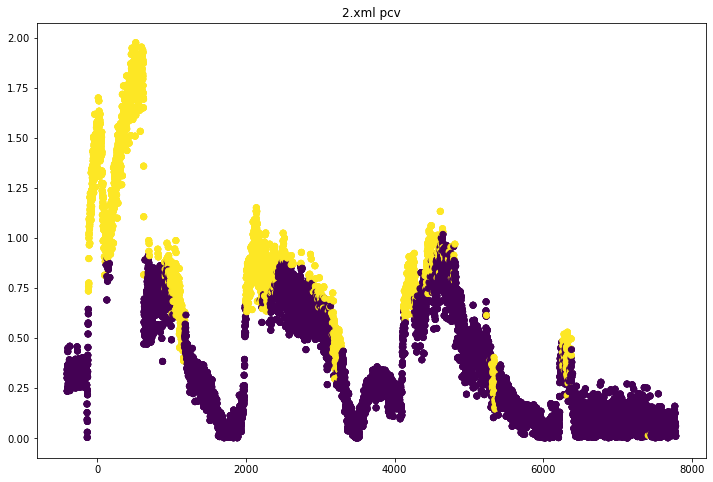

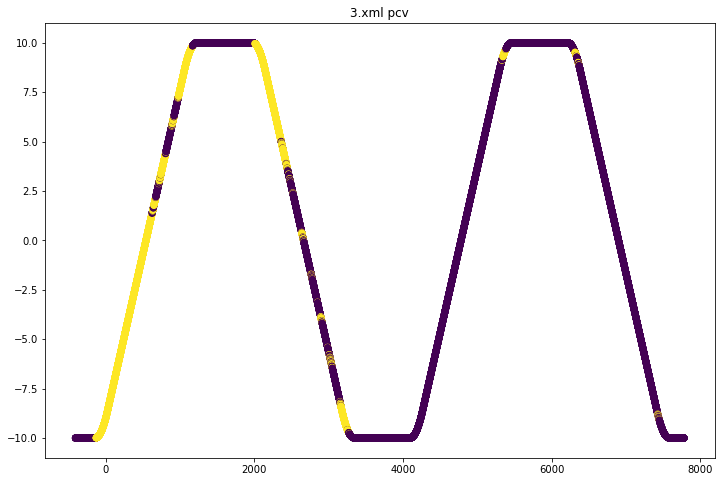

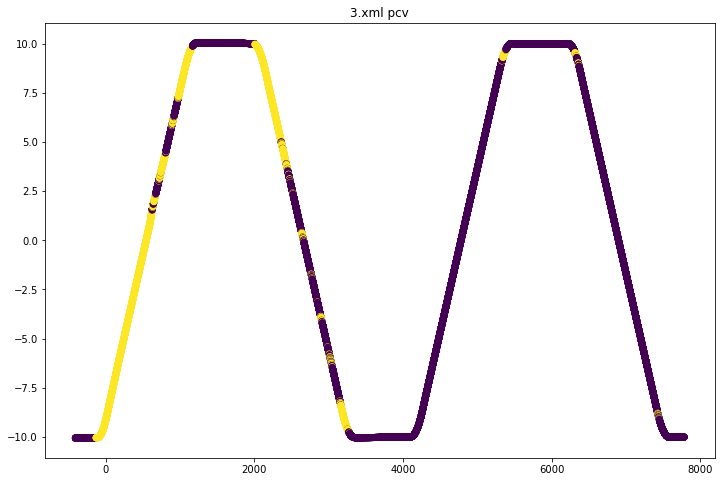

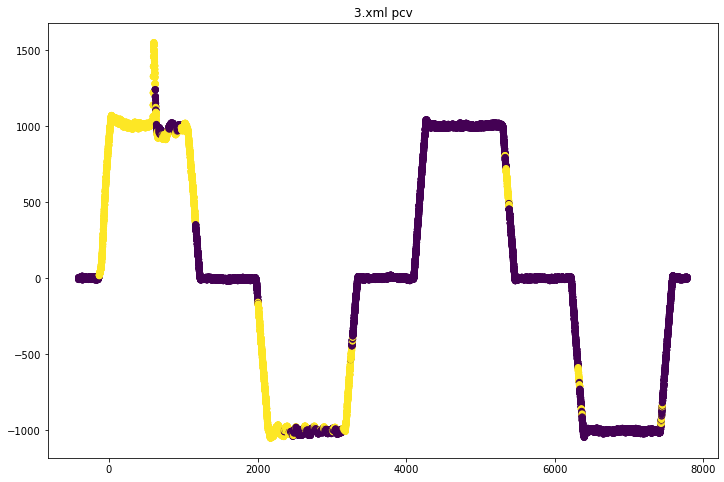

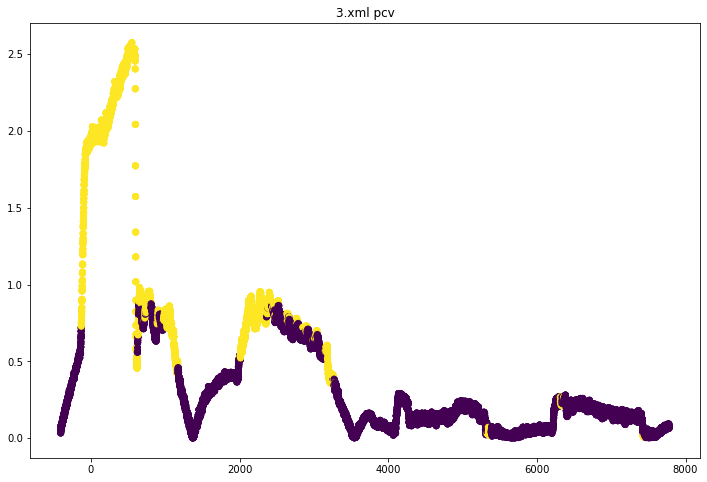

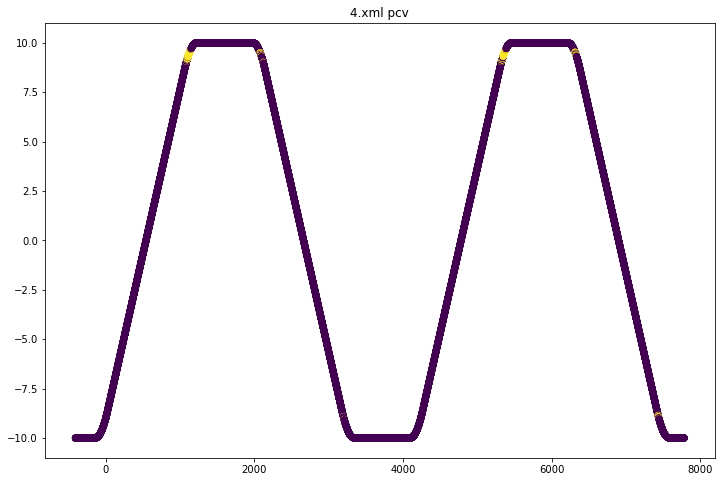

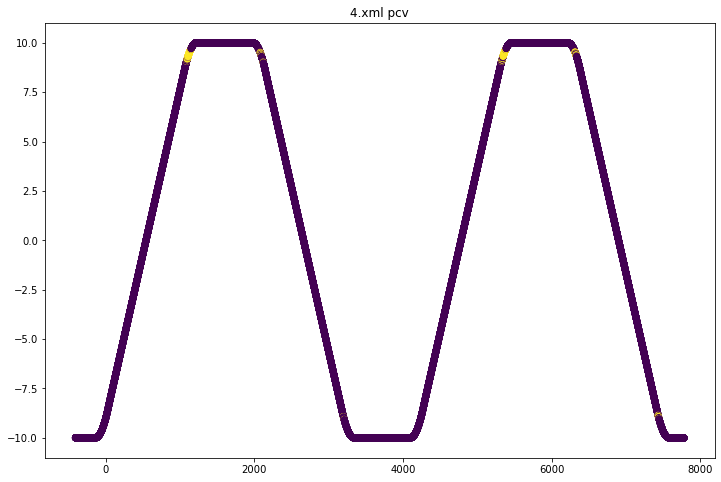

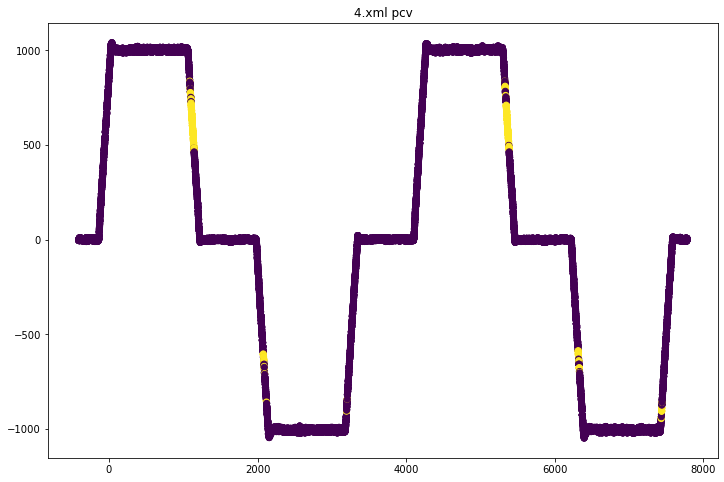

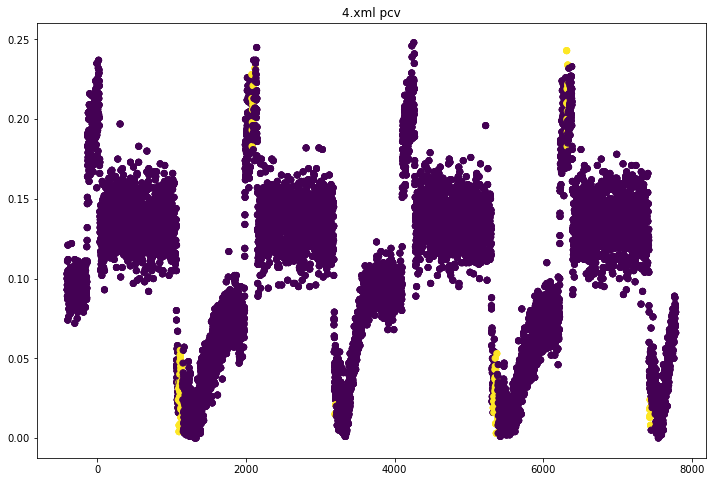

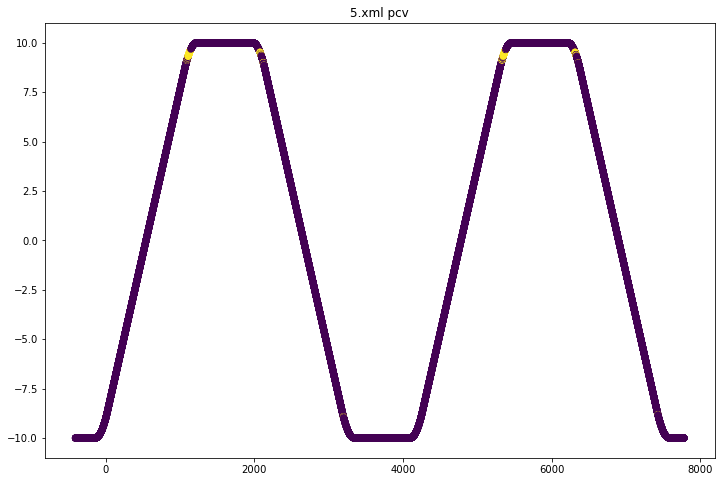

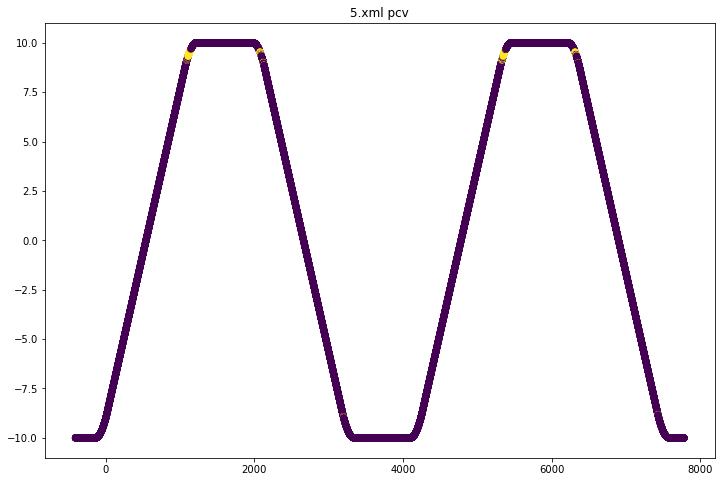

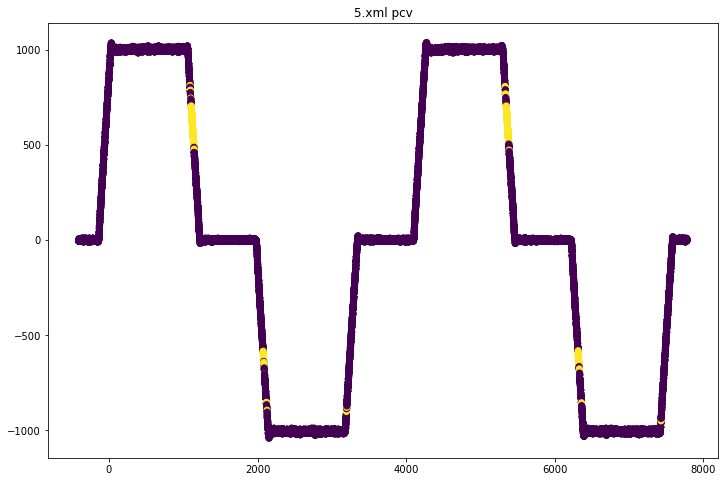

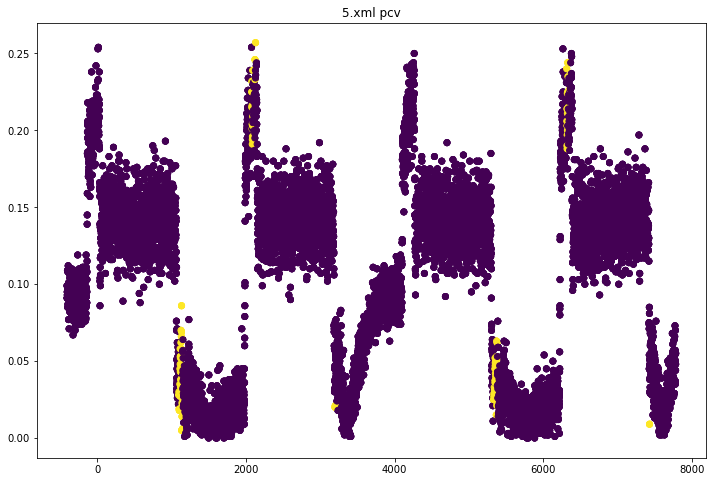

In [15]:
for n in range(1, 6):
    x = ['pcv_x', 'pcv_x', 'pcv_x', 'pcv_x']
    y = ['pcv_y', 'pfv_y', 'vfv_y', 'cv_y']
    for x, y in zip(x, y):
        df = data[data.xml == n].copy()
        plt.figure(figsize = (12, 8))
        plt.scatter(df[x], df[y], c=(df['anomaly'] > 1))
        plt.title(f'{n}.xml ' + x.replace('_x', ''))